# Regularized least squared problem with kernels from bottom up

### import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from numpy.random import randn

### General system for damped oscilator

$
\ddot{x}(t) + 2\zeta\omega_0 \dot{x}(t) + \omega_0^2 x(t) = 0
$

#### Description of variables:
- $ x(t) $: position 
- $ \dot{x}(t) $: Velocity 
- $ \ddot{x}(t) $: acceleration
- $ \zeta $: The damping factor, which determines how quickly the oscillations decay (due to friction or resistance).
- $ \omega_0 $: The natural frequency of the system (eigenfrequency)
- $ t $: Time unit.

In [3]:
def damped_oscillator(t, y):  #remember that independent value t comes first
    zeta = 1*0.4/np.sqrt(2)
    omega_0 = 0.1* 2* np.pi
    y_dot = - 2* zeta * omega_0 * y[1] - omega_0**2 * y[0] # x'' = -2*z*w0*x' - w0^2 * x rewritten as a system of first order 
    return [y[1], y_dot]  #y[1] = velocity and y_dot = acceleration. return both since system is rewritten as 2 first order diffs.

### solving the differential equation numerically with scipy

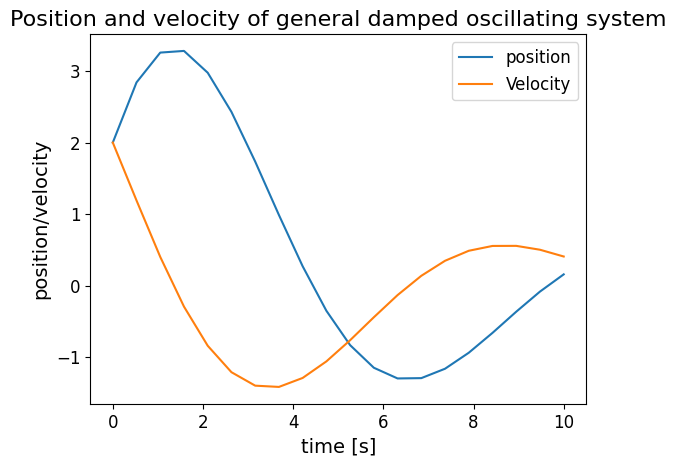

In [4]:
init_condition = [2, 2]  # Initial condition [position, velocity]
t_eval = np.linspace(0, 10, 20)
sol = solve_ivp(damped_oscillator, (0, 10), init_condition, t_eval = t_eval)#time interval first, then initial values for position and velocity
x,y  = sol.y        #sol.y contains solutions for position and velocity calculated over t_eval as a 2d array

plt.rcParams.update({
    'font.size': 12,           # Base font size
    'axes.titlesize': 16,      # Title font size
    'axes.labelsize': 14,      # Axis label font size
    'xtick.labelsize': 12,     # X-axis tick label size
    'ytick.labelsize': 12,     # Y-axis tick label size
    'legend.fontsize': 12,     # Legend font size
})
plt.plot(t_eval, x, label = "position")
plt.plot(t_eval, y, label = "Velocity")
plt.xlabel("time [s]")
plt.ylabel("position/velocity")
plt.title("Position and velocity of general damped oscillating system")
plt.legend()
plt.show()

### Phase plot of the oscilator

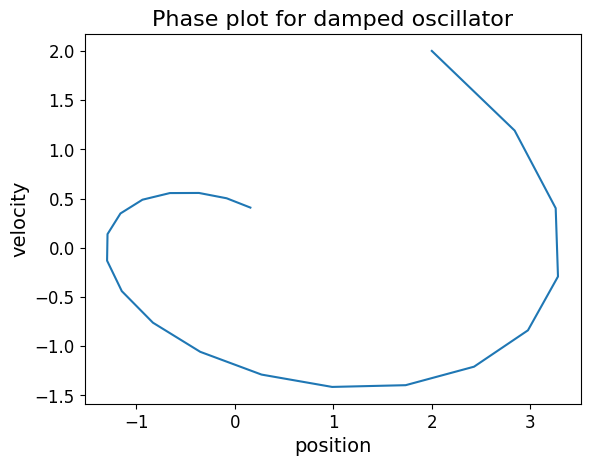

In [5]:
plt.plot(x, y)
plt.xlabel("position")
plt.ylabel("velocity")
plt.title("Phase plot for damped oscillator")
plt.show()

### Discretizing the dataset for with gaussian noise

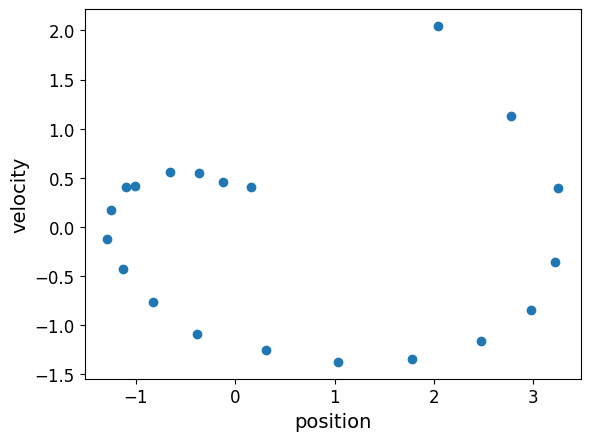

In [6]:
pos_data = x[::]
vel_data = y[::]
gaussian_noise = np.random.normal(0, 0.04, len(pos_data))
pos_data = pos_data + gaussian_noise
vel_data = vel_data + gaussian_noise
pos_data = np.column_stack((t_eval, pos_data))
plt.plot(pos_data[:,1], vel_data, 'o')
plt.xlabel("position")
plt.ylabel("velocity")
plt.show()


### Standardize the data

#### Tuning of $𝜆$ and $𝛼$
 - Lambda ($𝜆$): This is the regularization parameter that controls the trade-off between minimizing error on the training data and keeping the model complexity low. Higher $𝜆$ values apply stronger regularization, leading to simpler, smoother solutions that generalize better.

 - Sigma ($𝜎$): In the RBF kernel, $𝜎$, controls the spread of the kernel, defining how quickly similarity decays with distance. Smaller 
$𝜎$ results in a highly localized influence (risking overfitting), whereas larger $𝜎$ smooths the influence over a broader area (which may underfit).

### Computing the gassian kernel matrix

In [7]:
sigma, lam = [10, 0.0001]
def rbfkernel(x, z, sigma):
    k = np.exp(-(np.linalg.norm(x - z)**2)/(2 * sigma**2))
    return k

def gram(x_list, z_list, sigma):
    n = len(x_list)
    k_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            k_mat[i,j] = rbfkernel(x_list[i], z_list[j], sigma)
    return k_mat
    
K = gram(pos_data, pos_data, sigma)
K2 = gram(pos_data[:,1], pos_data[:,1], sigma) 

### Solve the minimization problem to obtain dual coefficients $a$

In [8]:
def dual_coeff(K, y, lambd):
    n = K.shape[0]
    K_reg = K + lambd * np.eye(n)
    alpha = np.linalg.solve(K_reg, y)
    return alpha
alfa = dual_coeff(K, vel_data, lam)  #1D column vector

### Estimate the function based on $a$ and kernel matrix

In [9]:
# Velocity estimation function
def f(a, x, pos_data, sigma):
    x = np.atleast_1d(x)
    n = x.shape[0]
    velocity = np.zeros(n)  # Rename the array to 'velocity'
    for i in range(n):
        tot = 0
        for j in range(len(a)):  # Use the length of coefficients 'a'
            tot += a[j] * rbfkernel(x[i], pos_data[j], sigma)
        velocity[i] = tot
    return velocity
vel = f(alfa, pos_data, pos_data, sigma)

### plot results

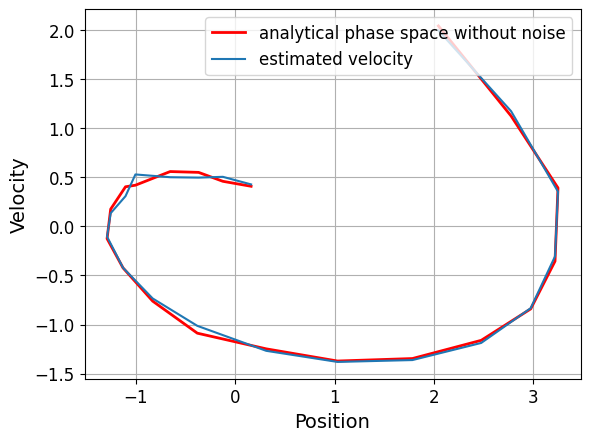

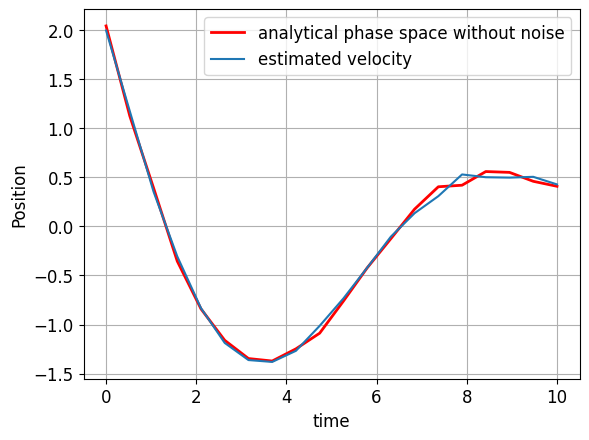

In [10]:

# Extract position and velocity data
positions = pos_data[:, 1]  # Assuming 2nd column corresponds to x1 positions
velocities = vel_data       # Assuming this is x2 (velocity data)

# Plot the trajectory

plt.plot(positions, velocities, 'r-', label="analytical phase space without noise", linewidth=2)
plt.plot(positions, vel, label = "estimated velocity")
# Add labels and legend
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.legend()
plt.grid()
plt.savefig("Phase_plot_time_included.png")
plt.show()

plt.plot(t_eval, velocities, 'r-', label="analytical phase space without noise", linewidth=2)
plt.plot(t_eval, vel, label = "estimated velocity")
# Add labels and legend
plt.xlabel("time", fontsize=12)
plt.ylabel("Position", fontsize=12)
plt.legend()
plt.grid()
plt.savefig("velocity_plot_time_included.png")
plt.show()


In [11]:
def evaluate_mse(true_q, pred_q):
    mse_q = np.mean((true_q - pred_q)**2)
    return mse_q
mse = evaluate_mse(velocities, vel)
mse

0.0024082182785678625